In [1]:
import pandas as pd
from theano import shared
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100




WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
dta = pd.read_csv('Reco_HH_14Days.csv')

dta[['TIMESTAMP_START']] = (dta[['TIMESTAMP_START']].applymap(str).applymap(
    lambda s: "{}/{}/{} {}:{}".format(s[0:4], s[4:6], s[6:8], s[8:10], s[10:12])))

dta['TIMESTAMP_START'] = dta['TIMESTAMP_START'].astype('datetime64[ns]')

#mask = (dta['TIMESTAMP_START'] > '2005-05-01') & (dta['TIMESTAMP_START'] <= '2005-05-14')

dta.set_index(['TIMESTAMP_START'], inplace=True)

#dta = dta.resample('1H').mean()

dta.reset_index(inplace=True)



In [3]:
def norml(data):
    norm_data = (data-np.max(data))/(np.min(data)-np.max(data))
    return norm_data

In [4]:

ts = pd.DataFrame(dta.loc[:,['TIMESTAMP_START', 'TA_F','SW_IN_F','RECO_NT_VUT_50']])
ts['RECO_NT_VUT_50'] = norml(ts['RECO_NT_VUT_50'])
ts['TA_F'] = norml(ts['TA_F'])


In [6]:
num_forecast = 48 * 2  # two days
data_training = ts[:-num_forecast]
data_test = ts[-num_forecast:]
#data_training
#data_training['TIMESTAMP_START'].tail(1)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats


def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

In [8]:
from functools import partial
from scipy.stats import norm
def schon_basis(x):
    return x 

def polynomial_basis(x, power):
    return x ** power

def gaussian_basis(x, mu, sigma):
    return norm(loc=np.mean(x), scale=sigma).pdf(x).astype(np.float32)

def _expand(x, bf, bf_args):
    return np.stack([bf(x, bf_arg) for bf_arg in bf_args], axis=1)

def expand_polynomial(x, degree=3):
    return _expand(x, bf=polynomial_basis, bf_args=range(1, degree + 1))

def expand_gaussian(x, mus=np.linspace(0, 1, 9), sigma=1):
    return _expand(x, bf=partial(gaussian_basis, sigma=sigma), bf_args=mus)


expand = expand_polynomial
#expand = expand_gaussian

In [132]:
#to check the basis function test it with values
#expand_polynomial(np.array([0.5, 1.5]), degree=3)

In [10]:
x=data_training['TA_F'].values
y = data_training['RECO_NT_VUT_50'].values


In [11]:

Phi = expand(x)
Phi_shared = shared(Phi)

with pm.Model() as model:
    w_0 = pm.Normal('w_0', mu=0, sigma=10)
    w_r = pm.Normal('w_r', mu=0, sigma=10, shape=Phi.shape[1])
    noise = 0.5
    mu = w_0 + w_r.dot(Phi_shared.T)
    
    t_obs = pm.Normal('t_obs', mu=mu, sigma=noise, observed=y)

In [12]:
with model:
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_r, w_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


/var/folders/v1/58yl0t_n2ng9vz587pfjhtpc0000gn/T/ipykernel_40482/3892976860.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, compact=False)


array([[<AxesSubplot:title={'center':'w_0'}>,
        <AxesSubplot:title={'center':'w_0'}>],
       [<AxesSubplot:title={'center':'w_r\n0'}>,
        <AxesSubplot:title={'center':'w_r\n0'}>],
       [<AxesSubplot:title={'center':'w_r\n1'}>,
        <AxesSubplot:title={'center':'w_r\n1'}>],
       [<AxesSubplot:title={'center':'w_r\n2'}>,
        <AxesSubplot:title={'center':'w_r\n2'}>]], dtype=object)

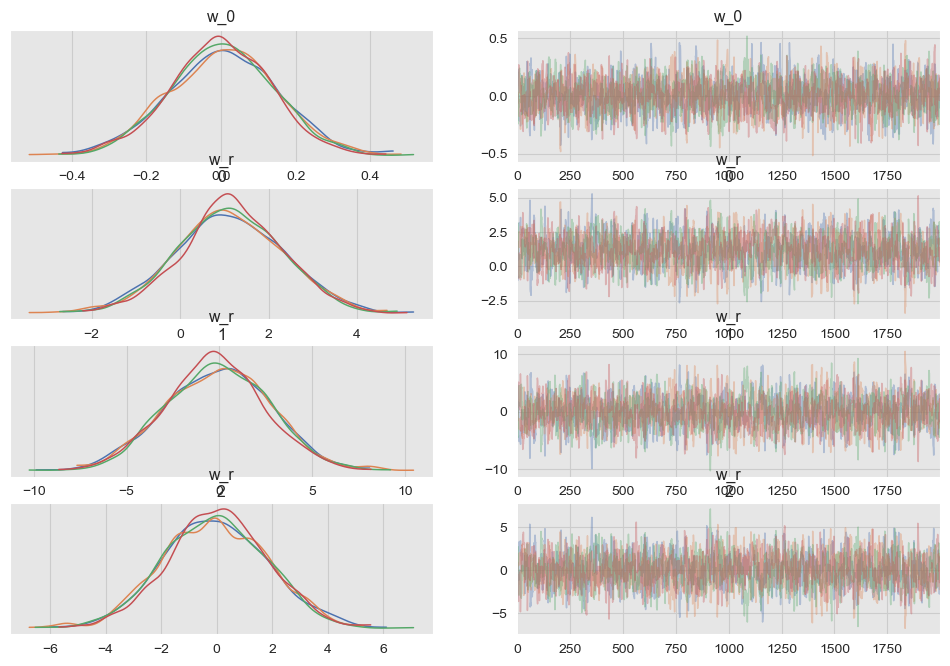

In [13]:
pm.traceplot(trace, compact=False)

array([<AxesSubplot:title={'center':'w_r\n0'}>,
       <AxesSubplot:title={'center':'w_r\n1'}>,
       <AxesSubplot:title={'center':'w_r\n2'}>], dtype=object)

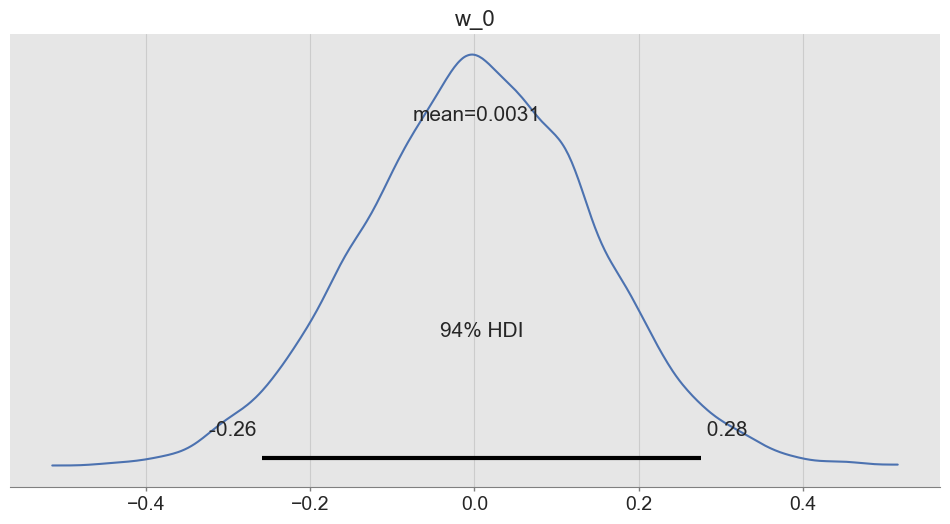

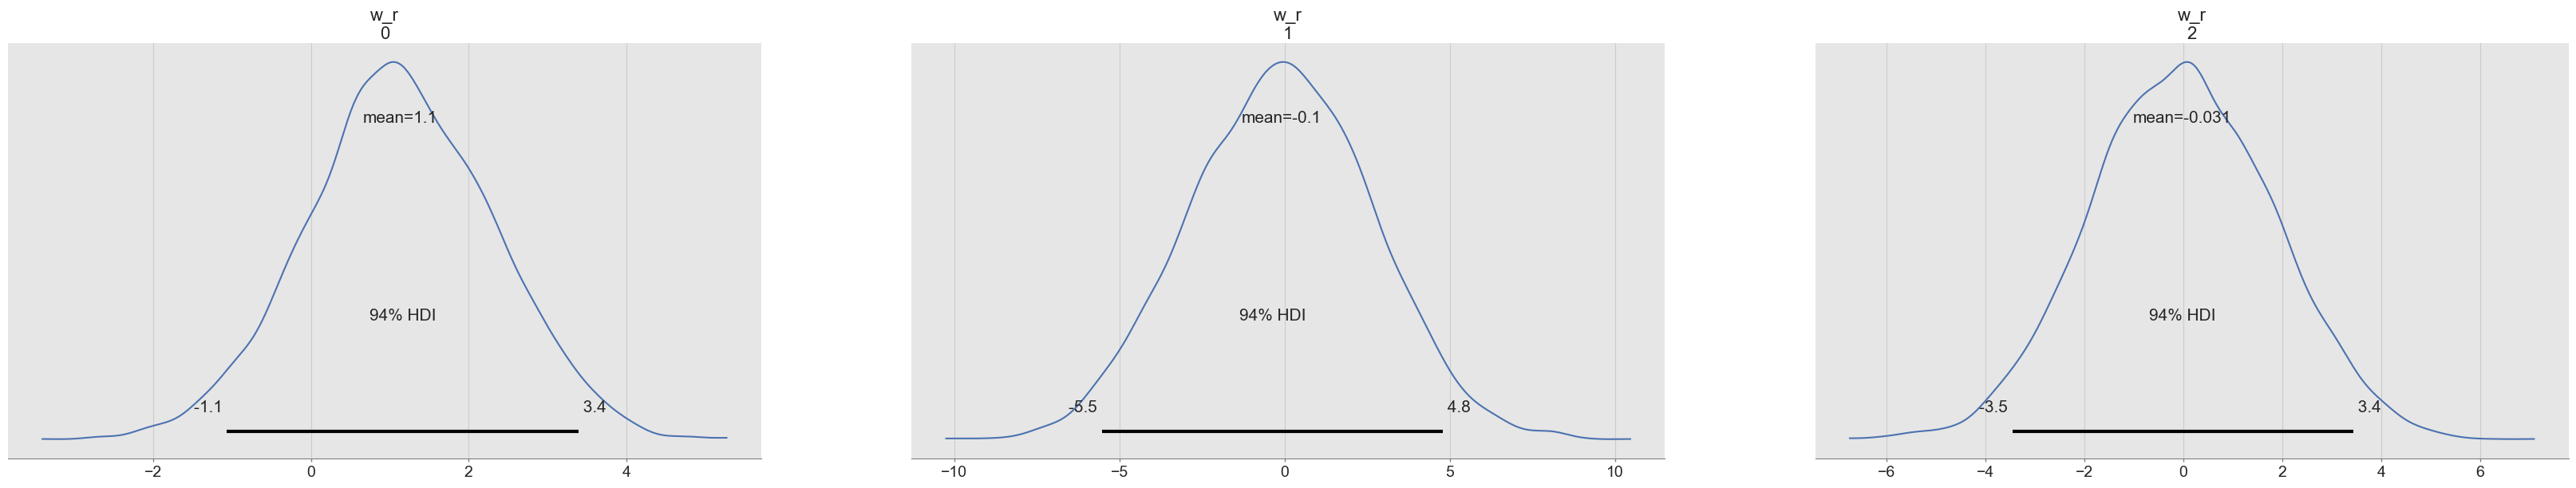

In [14]:
pm.plot_posterior(trace, var_names="w_0")
pm.plot_posterior(trace, var_names="w_r")

In [168]:
#with model:
    
   # data_train_pred_samples = pm.sample_posterior_predictive(trace, model=model, samples=10000)['t_obs']

    
    

/Users/sabazamankhani/miniforge3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [169]:
#m_1 = np.mean(data_train_pred_samples, axis=0)
#s_1 = np.std(data_train_pred_samples, axis=0)


In [15]:
#posterior predictive samples for a separate test set 
Phi_shared.set_value(expand(data_test['TA_F'].values))
predictive_samples = pm.sample_posterior_predictive(trace, model=model, samples=10000)['t_obs']

In [16]:
mean = np.mean(predictive_samples, axis=0)
std = np.std(predictive_samples, axis=0)

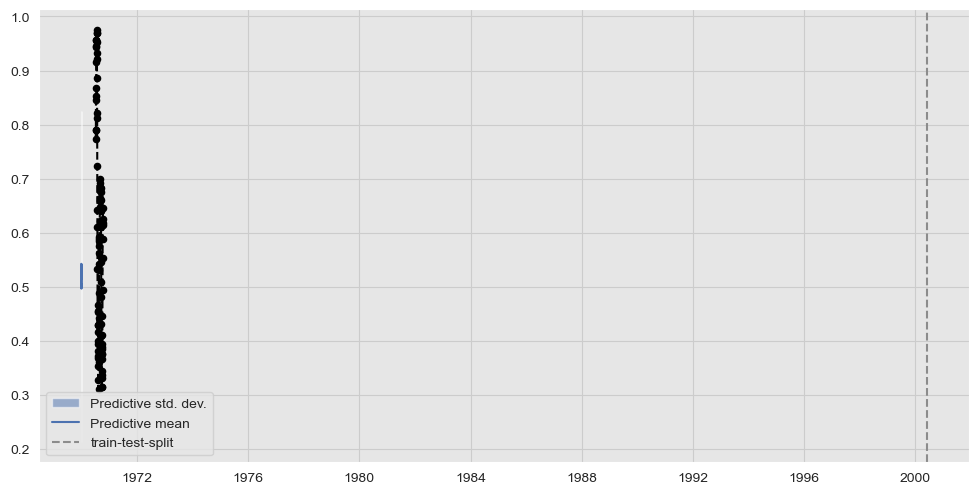

In [179]:

fig, ax = plt.subplots()
plt.fill_between(data_test['RECO_NT_VUT_50'].values, mean + std, mean - std, alpha = 0.5, label='Predictive std. dev.')
plt.plot(data_test['RECO_NT_VUT_50'], mean, label='Predictive mean')

plot_data(data_test['TIMESTAMP_START'].index.values, data_test['RECO_NT_VUT_50'])
plot_truth(data_test['TIMESTAMP_START'].index.values, data_test['RECO_NT_VUT_50'], label=None)
ax.axvline(x=data_test['TIMESTAMP_START'].values.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
plt.legend()



[Text(0.5, 1.0, 'Model Predictions'), Text(0.5, 0, 'time'), Text(0, 0.5, '')]

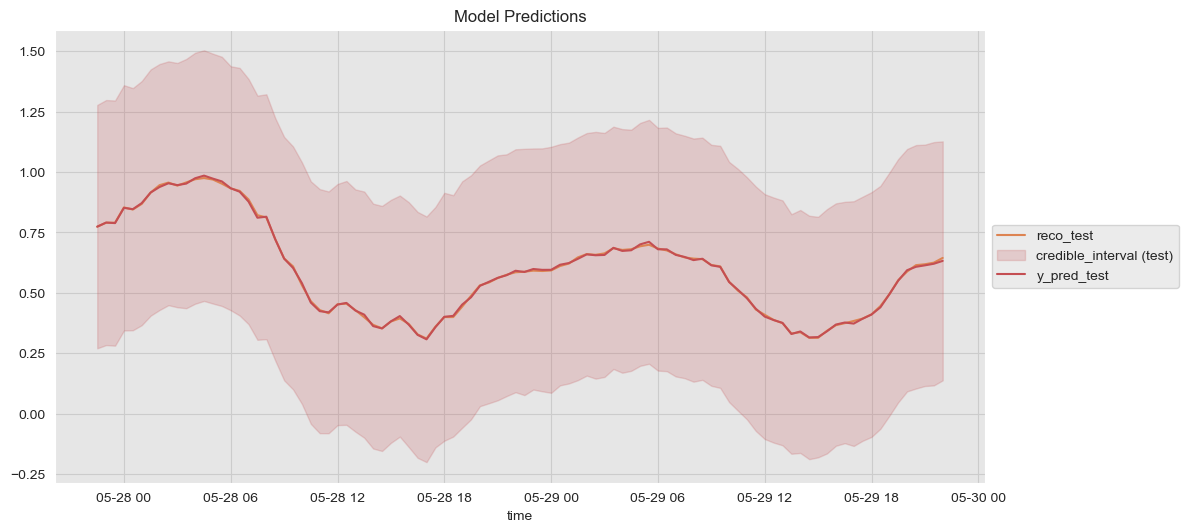

In [17]:
#'TIMESTAMP_START', 'TA_F','SW_IN_F','RECO_NT_VUT_50'
fig, ax = plt.subplots()
#sns.lineplot(x=data_training['TIMESTAMP_START'].values.flatten(), y=data_training['RECO_NT_VUT_50'].values.flatten(), color=sns_c[0], label='reco_train', ax=ax)
sns.lineplot(x=data_test['TIMESTAMP_START'].values.flatten(), y=data_test['RECO_NT_VUT_50'].values.flatten(), color=sns_c[1], label='reco_test', ax=ax)
#ax.fill_between(
#    x=data_training['TIMESTAMP_START'].values.flatten(), 
 #   y1=m_1-s_1,
#    y2=m_1+s_1, 
#    color=sns_c[2], 
#    alpha=0.2, 
 #   label='credible_interval (train)'
#)
#sns.lineplot(x=data_test['TIMESTAMP_START'].values.flatten(), y=m, color=sns_c[2], label='y_pred_train', ax=ax)
ax.fill_between(
    x=data_test['TIMESTAMP_START'].values.flatten(), 
    y1=mean-std, 
    y2=mean+std, 
    color=sns_c[3], 
    alpha=0.2, 
    label='credible_interval (test)'
)
sns.lineplot(x=data_test['TIMESTAMP_START'].values.flatten(), y=mean, color=sns_c[3], label='y_pred_test', ax=ax)
#ax.axvline(x=data_training['TIMESTAMP_START'].values.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Model Predictions', xlabel='time', ylabel='')